In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt

# Load and plot the data

In [2]:
df = pd.read_csv("data/data-lda.txt")
print(len(df))
df.head(5)

1117


,PersonID,ItemID
0,1,105
1,1,80
2,1,54
3,1,120
4,1,6


In [3]:
df.nunique()

PersonID     50
ItemID      112
dtype: int64

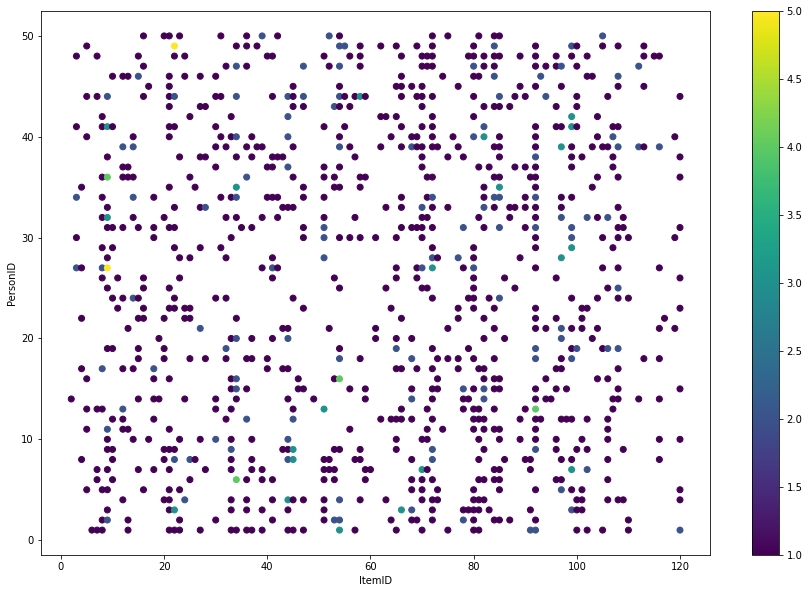

In [4]:
# Fig 11.5
fig, ax = plt.subplots(1,1, figsize=(15, 10))
count_user_item = df.groupby(by=["PersonID", "ItemID"]).size()

plt.scatter(x=count_user_item.index.get_level_values(1), y=count_user_item.index.get_level_values(0), c=count_user_item.values, marker='o')
plt.xlabel("ItemID")
plt.ylabel("PersonID")
plt.colorbar()

Text(0.5, 0, 'purchase count (per item)')

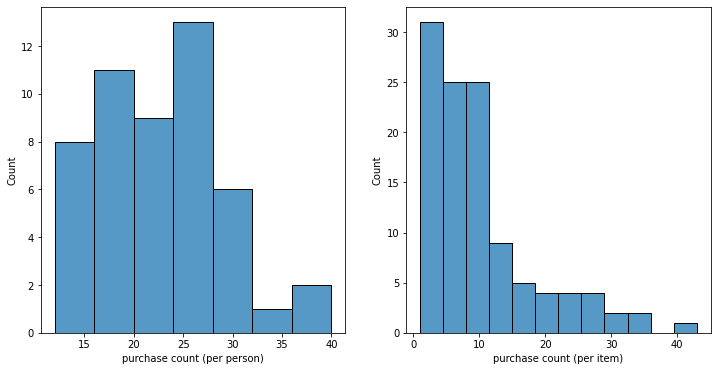

In [5]:
# Fig 11.6
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.histplot(ax=axes[0], x= df["PersonID"].value_counts().values)
axes[0].set_xlabel("purchase count (per person)")
sns.histplot(ax=axes[1], x= df["ItemID"].value_counts().values)
axes[1].set_xlabel("purchase count (per item)")

# Run Stan

In [6]:
N = 50
I = 120
K = 6
data = {
    "E": len(df),
    "N": N,
    "I": I, 
    "K": K,
    "PersonID": df["PersonID"].values,
    "ItemID": df["ItemID"].values,
    "Alpha": 0.5 * np.ones(I)
}

In [7]:
model = CmdStanModel(stan_file="model/model11-8.stan")
print(model)

INFO:cmdstanpy:compiling stan program, exe file: /workdir/chapter11/model/model11-8
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /workdir/chapter11/model/model11-8


CmdStanModel: name=model11-8
	 stan_file=/workdir/chapter11/model/model11-8.stan
	 exe_file=/workdir/chapter11/model/model11-8
	 compiler_optons=stanc_options=None, cpp_options=None


In [8]:
fit_vb = model.variational(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [9]:
fit_vb.variational_sample.shape

(1000, 1023)

# Plot the result

In [10]:
def get_param_mean(fit, name, I, J):
    out = np.zeros((I, J))

    for i in range(I):
        for j in range(J):
            idx = fit.column_names.index(f"{name}.{i+1}.{j+1}")
            out[i, j] = fit.variational_sample.iloc[:, idx].mean()
            
    return out

In [11]:
theta = get_param_mean(fit_vb, "theta", N, K)
phi = get_param_mean(fit_vb, "phi", K, I)

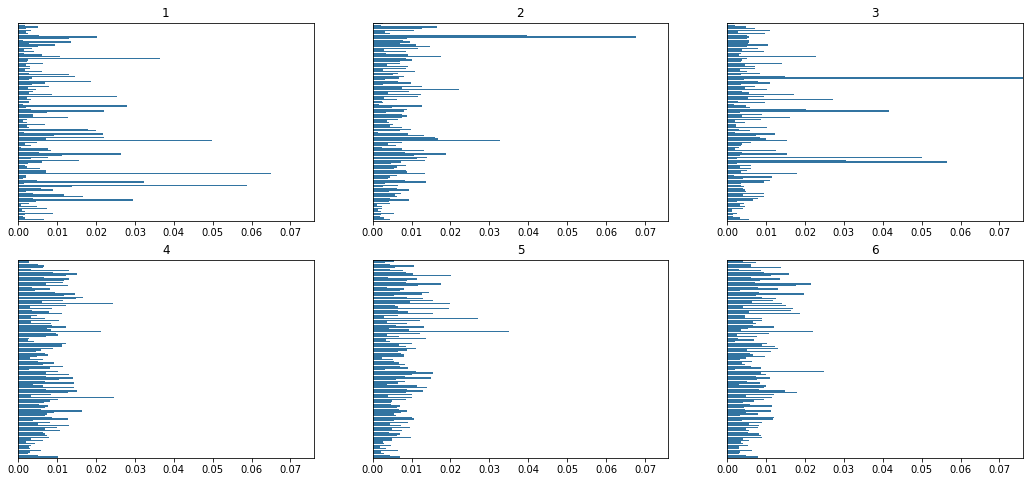

In [12]:
# Fig 11.11 left
phimax = phi.max()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
for i, ax in enumerate(np.ravel(axes)):
    sns.barplot(ax=ax, x=phi[i], y=np.arange(I), color="C0", orient="h")
    ax.set_yticks([])
    ax.set_title(f"{i+1}")
    ax.set_xlim(0, phimax)
fig.show()

<AxesSubplot:>

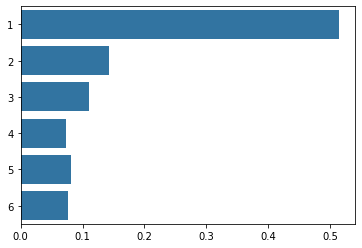

In [13]:
ax = plt.subplot(111)
i = 40
sns.barplot(ax=ax, x=theta[i], y=np.arange(K)+1, color="C0", orient="h")

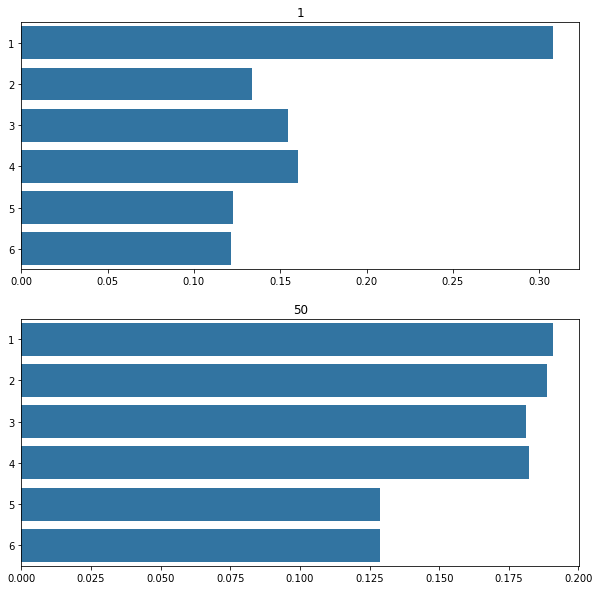

In [14]:
# Fig 11.11 right
users = [1, 50]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for user, ax in zip(users, np.ravel(axes)):
    sns.barplot(ax=ax, x=theta[user-1], y=np.arange(K)+1, color="C0", orient="h")
    ax.set_title(user)